<a href="https://colab.research.google.com/github/Sesa-ja/AssetManager/blob/master/InkubasiaLAB_2025_Netflix_Alexander_Waseem_titles_with_credits_a_Final_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Netflix Dataset

For this project, we'll be using a netflix dataset (Netflix is an American version of Zeflix) to answer the question:

**What makes a movie successful? What is a “successful movie”?**

You will need to define how to answer this question and build up the models and dataset to produce an accurate answer.

Note: The following introduction is copied from the Netflix One-Pager document for your convenience so please refer back to that document for more details.
## Netflix - TV Shows and Movies

This dataset was created to list all shows available on Netflix streaming, and analyze the data to find interesting facts. This data was acquired in July 2022 containing data available in the United States.

## Content
This dataset has two files containing the titles (titles.csv) and the cast (credits.csv) for the title.

This dataset contains +5k unique titles on Netflix with 15 columns containing their information, including:

* id: The title ID on JustWatch.
* title: The name of the title.
* show_type: TV show or movie.
* description: A brief description.
* release_year: The release year.
* age_certification: The age certification.
* runtime: The length of the episode (SHOW) or movie.
* genres: A list of genres.
* production_countries: A list of countries that produced the title.
* seasons: Number of seasons if it's a SHOW.
* imdb_id: The title ID on IMDB.
* imdb_score: Score on IMDB.
* imdb_votes: Votes on IMDB.
* tmdb_popularity: Popularity on TMDB.
* tmdb_score: Score on TMDB.

And over +77k credits of actors and directors on Netflix titles with 5 columns containing their information, including:

* person_ID: The person ID on JustWatch.
* id: The title ID on JustWatch.
* name: The actor or director's name.
* character_name: The character name.
* role: ACTOR or DIRECTOR.

---

# Imports

In [ ]:
!pip install case-converter plotly seaborn statsmodels

# access to google drive
from google.colab import drive

# dataframe and data manipulation
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from caseconverter import snakecase
import graphviz

# ml model fitting
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# ml model scoring
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)

In [ ]:
ROOT = '/content/drive'
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# titles.csv
!gdown 1ttXJafl0m6UOtPp1XuvdhRTRRaf88WnH

Downloading...
From: https://drive.google.com/uc?id=1ttXJafl0m6UOtPp1XuvdhRTRRaf88WnH
To: /content/titles.csv
100% 2.03M/2.03M [00:00<00:00, 27.2MB/s]


In [ ]:
# credits.csv
!gdown 1mUYR8_NyAn6hGwEF_5RO87tCWf7OH6ze

Downloading...
From: https://drive.google.com/uc?id=1mUYR8_NyAn6hGwEF_5RO87tCWf7OH6ze
To: /content/credits.csv
100% 3.82M/3.82M [00:00<00:00, 81.7MB/s]


In [ ]:
!ls /content/

credits.csv  drive  sample_data  titles.csv


In [ ]:
titles_df = pd.read_csv("/content/titles.csv")
credits_df = pd.read_csv("/content/credits.csv")

---

# Problem Definition (Defining the question)

**How do given parameters predict success of a movie?**

---

# Exploring datasets

In [ ]:
print(titles_df.shape[0])
titles_df.head()

5850


id                                title   type  \
0  ts300399  Five Came Back: The Reference Films   SHOW   
1   tm84618                          Taxi Driver  MOVIE   
2  tm154986                          Deliverance  MOVIE   
3  tm127384      Monty Python and the Holy Grail  MOVIE   
4  tm120801                      The Dirty Dozen  MOVIE   

                                         description  release_year  \
0  This collection includes 12 World War II-era p...          1945   
1  A mentally unstable Vietnam War veteran works ...          1976   
2  Intent on seeing the Cahulawassee River before...          1972   
3  King Arthur, accompanied by his squire, recrui...          1975   
4  12 American military prisoners in World War II...          1967   

  age_certification  runtime                                       genres  \
0             TV-MA       51                            ['documentation']   
1                 R      114                           ['drama', 'crime']   
2                 R      109  ['drama', 'action', 'thriller', 'european']   
3                PG       91              ['fantasy', 'action', 'comedy']   
4               NaN      150                            ['war', 'action']   

  production_countries  seasons    imdb_id  imdb_score  imdb_votes  \
0               ['US']      1.0        NaN         NaN         NaN   
1               ['US']      NaN  tt0075314         8.2    808582.0   
2               ['US']      NaN  tt0068473         7.7    107673.0   
3               ['GB']      NaN  tt0071853         8.2    534486.0   
4         ['GB', 'US']      NaN  tt0061578         7.7     72662.0   

   tmdb_popularity  tmdb_score  
0            0.600         NaN  
1           40.965       8.179  
2           10.010       7.300  
3           15.461       7.811  
4           20.398       7.600

In [ ]:
print(titles_df.dtypes)

id                       object
title                    object
type                     object
description              object
release_year              int64
age_certification        object
runtime                   int64
genres                   object
production_countries     object
seasons                 float64
imdb_id                  object
imdb_score              float64
imdb_votes              float64
tmdb_popularity         float64
tmdb_score              float64
dtype: object


In [ ]:
print(credits_df.shape[0])
credits_df.head()

77801


person_id       id             name                character   role
0       3748  tm84618   Robert De Niro            Travis Bickle  ACTOR
1      14658  tm84618     Jodie Foster            Iris Steensma  ACTOR
2       7064  tm84618    Albert Brooks                      Tom  ACTOR
3       3739  tm84618    Harvey Keitel  Matthew 'Sport' Higgins  ACTOR
4      48933  tm84618  Cybill Shepherd                    Betsy  ACTOR

In [ ]:
print(credits_df.dtypes)

person_id     int64
id           object
name         object
character    object
role         object
dtype: object


In [ ]:
credits_df['name'].value_counts()

name
Boman Irani              25
Kareena Kapoor Khan      25
Shah Rukh Khan           23
Takahiro Sakurai         21
Priyanka Chopra Jonas    20
                         ..
Sangyoon Lee              1
Bae Young-ran             1
Park Jeong-gi             1
Yoon Jung-ro              1
Kim Moon-hak              1
Name: count, Length: 54314, dtype: int64

We'll use above or equal `7.5` as success:

`imdb_score` > `7.5` => the movie is succesfull

The following parameters were chosen to train the models:

`show_type` `release_year` `age_certification` `runtime` `genres` `production_countries` `seasons` `imdb_votes` `tmdb_popularity`

We'll "explode" those parameters in the following ways:

- one-hot encoding:
  - `show_type`
  - `age_certification`
  - `genres`
  - `production_countries`

- normalizing:
  - `runtime`
  - `seasons`
  - `imdb_votes`
  - `tmdb_popularity`

- classifying + one-hot encoding:
  - `release_year`

---

# Gluing data

In [ ]:
titles_df.loc[546, 'production_countries'] = "['LB']"

We glue `titles_df` and `credits_df`, adding actors to movies

In [ ]:
actors_by_movie = credits_df.groupby('id')['name'].apply(list).reset_index()
total_df = titles_df.join(actors_by_movie.set_index('id'), on='id', rsuffix="_actor")

total_df.head()

id                                title   type  \
0  ts300399  Five Came Back: The Reference Films   SHOW   
1   tm84618                          Taxi Driver  MOVIE   
2  tm154986                          Deliverance  MOVIE   
3  tm127384      Monty Python and the Holy Grail  MOVIE   
4  tm120801                      The Dirty Dozen  MOVIE   

                                         description  release_year  \
0  This collection includes 12 World War II-era p...          1945   
1  A mentally unstable Vietnam War veteran works ...          1976   
2  Intent on seeing the Cahulawassee River before...          1972   
3  King Arthur, accompanied by his squire, recrui...          1975   
4  12 American military prisoners in World War II...          1967   

  age_certification  runtime                                       genres  \
0             TV-MA       51                            ['documentation']   
1                 R      114                           ['drama', 'crime']   
2                 R      109  ['drama', 'action', 'thriller', 'european']   
3                PG       91              ['fantasy', 'action', 'comedy']   
4               NaN      150                            ['war', 'action']   

  production_countries  seasons    imdb_id  imdb_score  imdb_votes  \
0               ['US']      1.0        NaN         NaN         NaN   
1               ['US']      NaN  tt0075314         8.2    808582.0   
2               ['US']      NaN  tt0068473         7.7    107673.0   
3               ['GB']      NaN  tt0071853         8.2    534486.0   
4         ['GB', 'US']      NaN  tt0061578         7.7     72662.0   

   tmdb_popularity  tmdb_score  \
0            0.600         NaN   
1           40.965       8.179   
2           10.010       7.300   
3           15.461       7.811   
4           20.398       7.600   

                                                name  
0                                                NaN  
1  [Robert De Niro, Jodie Foster, Albert Brooks, ...  
2  [Jon Voight, Burt Reynolds, Ned Beatty, Ronny ...  
3  [Graham Chapman, John Cleese, Eric Idle, Terry...  
4  [Lee Marvin, Ernest Borgnine, Charles Bronson,...

We consider `fame` to be the total amount of movies an actor/director was at

`total_actor_fame` = `fame` of all the actors+directors in a movie

In [ ]:
name_counts = credits_df['name'].value_counts()

def name_to_fame(x):
  # print(type(x))
  if type(x) == list:
    total_fame = 0
    for k in x:
      total_fame += name_counts[k]
    # print(total_fame)
    return total_fame
  else:
    return 0

expanded_total_df = total_df
expanded_total_df['total_actor_fame'] = total_df["name"].map(name_to_fame)
print(expanded_total_df.head(5).to_markdown(tablefmt="psql"))

+----+----------+-------------------------------------+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+---------------------+-----------+---------------------------------------------+------------------------+-----------+-----------+--------------+--------------+-------------------+--------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

We classify `release_year` into `release_decade`

In [ ]:
print(sorted(expanded_total_df['release_year']))

[1945, 1954, 1954, 1956, 1958, 1959, 1960, 1961, 1963, 1966, 1967, 1967, 1969, 1969, 1971, 1972, 1972, 1972, 1973, 1974, 1975, 1975, 1976, 1976, 1976, 1977, 1978, 1979, 1979, 1979, 1979, 1979, 1980, 1980, 1980, 1981, 1981, 1981, 1982, 1982, 1982, 1982, 1982, 1982, 1983, 1983, 1983, 1983, 1984, 1984, 1984, 1984, 1984, 1984, 1985, 1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1987, 1987, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1991, 1991, 1991, 1991, 1991, 1991, 1991, 1991, 1991, 1991, 1991, 1991, 1991, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 199

In [ ]:
def year_to_decade(x):
  if x < 1950:
    return '1940s'
  elif x < 1960:
    return '1950s'
  elif x < 1970:
    return '1960s'
  elif x < 1980:
    return '1970s'
  elif x < 1990:
    return '1980s'
  elif x < 2000:
    return '1990s'
  elif x < 2010:
    return '2000s'
  elif x < 2020:
    return '2010s'
  else:
    return '2020s'

expanded_total_df['release_decade'] = total_df["release_year"].map(year_to_decade)
print(expanded_total_df.head().to_markdown(tablefmt="psql"))

+----+----------+-------------------------------------+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+---------------------+-----------+---------------------------------------------+------------------------+-----------+-----------+--------------+--------------+-------------------+--------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

---

# Cleaning data

In [ ]:
print('Rows amount =', titles_df.shape[0])
titles_df.isna().sum()

Rows amount = 5850


id                         0
title                      1
type                       0
description               18
release_year               0
age_certification       2619
runtime                    0
genres                     0
production_countries       0
seasons                 3744
imdb_id                  403
imdb_score               482
imdb_votes               498
tmdb_popularity           91
tmdb_score               311
dtype: int64

We remove rows with **null** `imdb_score` `imdb_votes` `tmdb_popularity`

In [ ]:
clean_titles_df = expanded_total_df.dropna(subset=['imdb_score']).dropna(subset=['imdb_votes']).dropna(subset=['tmdb_popularity'])
print('Rows amount =', clean_titles_df.shape[0])
clean_titles_df.isna().sum()

Rows amount = 5279


id                         0
title                      0
type                       0
description                2
release_year               0
age_certification       2284
runtime                    0
genres                     0
production_countries       0
seasons                 3365
imdb_id                    0
imdb_score                 0
imdb_votes                 0
tmdb_popularity            0
tmdb_score               148
name                     231
total_actor_fame           0
release_decade             0
dtype: int64

We replace missing amount of seasons with `0`

In [ ]:
clean_titles_df['converted_seasons'] = clean_titles_df["seasons"].fillna(0)
clean_titles_df.head()

id                            title   type  \
1   tm84618                      Taxi Driver  MOVIE   
2  tm154986                      Deliverance  MOVIE   
3  tm127384  Monty Python and the Holy Grail  MOVIE   
4  tm120801                  The Dirty Dozen  MOVIE   
5   ts22164     Monty Python's Flying Circus   SHOW   

                                         description  release_year  \
1  A mentally unstable Vietnam War veteran works ...          1976   
2  Intent on seeing the Cahulawassee River before...          1972   
3  King Arthur, accompanied by his squire, recrui...          1975   
4  12 American military prisoners in World War II...          1967   
5  A British sketch comedy series with the shows ...          1969   

  age_certification  runtime                                       genres  \
1                 R      114                           ['drama', 'crime']   
2                 R      109  ['drama', 'action', 'thriller', 'european']   
3                PG       91              ['fantasy', 'action', 'comedy']   
4               NaN      150                            ['war', 'action']   
5             TV-14       30                       ['comedy', 'european']   

  production_countries  seasons    imdb_id  imdb_score  imdb_votes  \
1               ['US']      NaN  tt0075314         8.2    808582.0   
2               ['US']      NaN  tt0068473         7.7    107673.0   
3               ['GB']      NaN  tt0071853         8.2    534486.0   
4         ['GB', 'US']      NaN  tt0061578         7.7     72662.0   
5               ['GB']      4.0  tt0063929         8.8     73424.0   

   tmdb_popularity  tmdb_score  \
1           40.965       8.179   
2           10.010       7.300   
3           15.461       7.811   
4           20.398       7.600   
5           17.617       8.306   

                                                name  total_actor_fame  \
1  [Robert De Niro, Jodie Foster, Albert Brooks, ...                77   
2  [Jon Voight, Burt Reynolds, Ned Beatty, Ronny ...                29   
3  [Graham Chapman, John Cleese, Eric Idle, Terry...               185   
4  [Lee Marvin, Ernest Borgnine, Charles Bronson,...                64   
5  [Graham Chapman, Michael Palin, Terry Jones, E...                74   

  release_decade  converted_seasons  
1          1970s                0.0  
2          1970s                0.0  
3          1970s                0.0  
4          1960s                0.0  
5          1960s                4.0

In [ ]:
credits_df.isna().sum()

person_id       0
id              0
name            0
character    9772
role            0
dtype: int64

---

# Visualizing data

In [ ]:
fig = px.histogram(clean_titles_df, x="imdb_score", title="")
fig.update_traces(marker_line_color="black", marker_line_width=1)
fig.show()

In [ ]:
fig = px.histogram(clean_titles_df, x="imdb_score", color="type", title="")
fig.update_traces(marker_line_color="black", marker_line_width=1)
fig.show()

In [ ]:
fig = px.histogram(clean_titles_df, x="imdb_score", color="age_certification", title="")
fig.update_traces(marker_line_color="black", marker_line_width=1)
fig.show()

In [ ]:
fig = px.histogram(clean_titles_df, x="imdb_score", color="genres", title="")
fig.update_traces(marker_line_color="black", marker_line_width=1)
fig.show()

In [ ]:
fig = px.histogram(clean_titles_df, x="imdb_score", color="production_countries", title="")
fig.update_traces(marker_line_color="black", marker_line_width=1)
fig.show()

In [ ]:
fig = px.scatter(clean_titles_df, x="runtime", y="imdb_score", title="")
fig.update_traces(marker_line_color="black", marker_line_width=1)
fig.show()

In [ ]:
fig = px.scatter(clean_titles_df, x="seasons", y="imdb_score", title="")
fig.update_traces(marker_line_color="black", marker_line_width=1)
fig.show()

In [ ]:
fig = px.scatter(clean_titles_df, x="release_year", y="imdb_score", title="")
fig.update_traces(marker_line_color="black", marker_line_width=1)
fig.show()

In [ ]:
fig = px.histogram(credits_df, x="name", title="")
fig.update_traces(marker_line_color="black", marker_line_width=1)
fig.show()

From the graphs we prove concur that our chosen parameters may have a predictive capability and therefore we need to include them into the model training after proper conversions

Additionally, actor data (`credits_df`) could prove to be useful for training as well

---

# Converting data


We define movie's success


In [ ]:
def score_to_success(x):
  if x >= 7.5:
    return 1 #True
  return 0 #False

clean_titles_df['is_successful'] = clean_titles_df["imdb_score"].map(score_to_success)

clean_titles_df.head(3)

id                            title   type  \
1   tm84618                      Taxi Driver  MOVIE   
2  tm154986                      Deliverance  MOVIE   
3  tm127384  Monty Python and the Holy Grail  MOVIE   

                                         description  release_year  \
1  A mentally unstable Vietnam War veteran works ...          1976   
2  Intent on seeing the Cahulawassee River before...          1972   
3  King Arthur, accompanied by his squire, recrui...          1975   

  age_certification  runtime                                       genres  \
1                 R      114                           ['drama', 'crime']   
2                 R      109  ['drama', 'action', 'thriller', 'european']   
3                PG       91              ['fantasy', 'action', 'comedy']   

  production_countries  seasons    imdb_id  imdb_score  imdb_votes  \
1               ['US']      NaN  tt0075314         8.2    808582.0   
2               ['US']      NaN  tt0068473         7.7    107673.0   
3               ['GB']      NaN  tt0071853         8.2    534486.0   

   tmdb_popularity  tmdb_score  \
1           40.965       8.179   
2           10.010       7.300   
3           15.461       7.811   

                                                name  total_actor_fame  \
1  [Robert De Niro, Jodie Foster, Albert Brooks, ...                77   
2  [Jon Voight, Burt Reynolds, Ned Beatty, Ronny ...                29   
3  [Graham Chapman, John Cleese, Eric Idle, Terry...               185   

  release_decade  converted_seasons  is_successful  
1          1970s                0.0              1  
2          1970s                0.0              1  
3          1970s                0.0              1

In [ ]:
clean_titles_df['is_successful'].value_counts()

is_successful
0    4175
1    1104
Name: count, dtype: int64

Applying one-hot encoding for appropriate columns

In [ ]:
clean_titles_df['type'].value_counts()

type
MOVIE    3365
SHOW     1914
Name: count, dtype: int64

In [ ]:
types_df = pd.get_dummies(clean_titles_df['type'], drop_first=True, dtype="int").reset_index(drop=True)
types_df.head()

SHOW
0     0
1     0
2     0
3     0
4     1

In [ ]:
clean_titles_df['age_certification'].value_counts()

age_certification
TV-MA    831
R        528
TV-14    432
PG-13    428
PG       221
TV-PG    168
TV-Y7    110
TV-Y      94
G         93
TV-G      75
NC-17     15
Name: count, dtype: int64

In [ ]:
age_df = pd.get_dummies(clean_titles_df['age_certification'], drop_first=True, dtype="int").reset_index(drop=True)
age_df.head()

NC-17  PG  PG-13  R  TV-14  TV-G  TV-MA  TV-PG  TV-Y  TV-Y7
0      0   0      0  1      0     0      0      0     0      0
1      0   0      0  1      0     0      0      0     0      0
2      0   1      0  0      0     0      0      0     0      0
3      0   0      0  0      0     0      0      0     0      0
4      0   0      0  0      1     0      0      0     0      0

In [ ]:
clean_titles_df['release_decade'].value_counts()

release_decade
2010s    3043
2020s    1700
2000s     340
1990s     114
1980s      51
1970s      18
1960s       8
1950s       5
Name: count, dtype: int64

In [ ]:
year_df = pd.get_dummies(clean_titles_df['release_decade'], drop_first=True, dtype="int").reset_index(drop=True)
year_df.head()

1960s  1970s  1980s  1990s  2000s  2010s  2020s
0      0      1      0      0      0      0      0
1      0      1      0      0      0      0      0
2      0      1      0      0      0      0      0
3      1      0      0      0      0      0      0
4      1      0      0      0      0      0      0

Applying one-hot encoding to columns with multiple params using `MultiLabelBinarizer`

In [ ]:
clean_titles_df['genres'].value_counts()

genres
['comedy']                                                        431
['drama']                                                         256
['documentation']                                                 254
['drama', 'romance']                                              120
['comedy', 'drama']                                               119
                                                                 ... 
['thriller', 'animation', 'family']                                 1
['family', 'animation', 'comedy', 'fantasy', 'european']            1
['action', 'scifi', 'thriller', 'european']                         1
['thriller', 'action', 'drama', 'crime', 'horror', 'european']      1
['drama', 'action', 'war', 'history']                               1
Name: count, Length: 1690, dtype: int64

In [ ]:
mlb_genre = MultiLabelBinarizer()

ft_genres = mlb_genre.fit_transform(clean_titles_df['genres'].map(literal_eval))
genres_df = pd.DataFrame(ft_genres, columns=mlb_genre.classes_).reset_index(drop=True)

print(genres_df.shape[0])

genres_df.head()

5279


action  animation  comedy  crime  documentation  drama  european  family  \
0       0          0       0      1              0      1         0       0   
1       1          0       0      0              0      1         1       0   
2       1          0       1      0              0      0         0       0   
3       1          0       0      0              0      0         0       0   
4       0          0       1      0              0      0         1       0   

   fantasy  history  horror  music  reality  romance  scifi  sport  thriller  \
0        0        0       0      0        0        0      0      0         0   
1        0        0       0      0        0        0      0      0         1   
2        1        0       0      0        0        0      0      0         0   
3        0        0       0      0        0        0      0      0         0   
4        0        0       0      0        0        0      0      0         0   

   war  western  
0    0        0  
1    0        0  
2    0        0  
3    1        0  
4    0        0

In [ ]:
clean_titles_df['production_countries'].value_counts()

production_countries
['US']                1808
['IN']                 561
['JP']                 242
['GB']                 203
['KR']                 191
                      ... 
['US', 'IE', 'CA']       1
['IR', 'US', 'FR']       1
['GB', 'AU', 'US']       1
['ES', 'DK']             1
['IT', 'ES', 'FR']       1
Name: count, Length: 423, dtype: int64

In [ ]:
mlb_production_country = MultiLabelBinarizer()

ft_countries = mlb_production_country.fit_transform(clean_titles_df['production_countries'].map(literal_eval))
production_countries_df = pd.DataFrame(ft_countries, columns=mlb_production_country.classes_).reset_index(drop=True)

print(production_countries_df.shape[0])

production_countries_df.head()


5279


AE  AL  AO  AR  AT  AU  BD  BE  BF  BG  ...  TZ  UA  US  UY  VA  VE  VN  \
0   0   0   0   0   0   0   0   0   0   0  ...   0   0   1   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0  ...   0   0   1   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   0   0  ...   0   0   1   0   0   0   0   
4   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

   XX  ZA  ZW  
0   0   0   0  
1   0   0   0  
2   0   0   0  
3   0   0   0  
4   0   0   0  

[5 rows x 106 columns]

Normalizing data in appropriate columns

In [ ]:
runtime_mean = clean_titles_df["runtime"].mean()
runtime_std = clean_titles_df["runtime"].std()
runtime_normalized_df = (clean_titles_df["runtime"] - runtime_mean) / runtime_std
runtime_normalized_df = runtime_normalized_df.reset_index(drop=True)

print(runtime_mean)
print(runtime_std)

runtime_normalized_df.head()

78.72513733661678
38.69448785488082


0    0.911625
1    0.782408
2    0.317225
3    1.841990
4   -1.259227
Name: runtime, dtype: float64

In [ ]:
seasons_mean = clean_titles_df["converted_seasons"].mean()
seasons_std = clean_titles_df["converted_seasons"].std()
seasons_normalized_df = (clean_titles_df["converted_seasons"] - seasons_mean) / seasons_std
seasons_normalized_df = seasons_normalized_df.reset_index(drop=True)

print(seasons_mean)
print(seasons_std)

seasons_normalized_df.head()

0.8126539117257057
1.9894432794347614


0   -0.408483
1   -0.408483
2   -0.408483
3   -0.408483
4    1.602130
Name: converted_seasons, dtype: float64

In [ ]:
imdb_votes_mean = clean_titles_df["imdb_votes"].mean()
imdb_votes_std = clean_titles_df["imdb_votes"].std()
imdb_votes_normalized_df = (clean_titles_df["imdb_votes"] - imdb_votes_mean) / imdb_votes_std
imdb_votes_normalized_df = imdb_votes_normalized_df.reset_index(drop=True)

print(imdb_votes_mean)
print(imdb_votes_std)

imdb_votes_normalized_df.head()

23754.88217465429
96442.77630298577


0    8.137749
1    0.870134
2    5.295691
3    0.507110
4    0.515011
Name: imdb_votes, dtype: float64

In [ ]:
tmdb_popularity_mean = clean_titles_df["tmdb_popularity"].mean()
tmdb_popularity_std = clean_titles_df["tmdb_popularity"].std()
tmdb_popularity_normalized_df = (clean_titles_df["tmdb_popularity"] - tmdb_popularity_mean) / tmdb_popularity_std
tmdb_popularity_normalized_df = tmdb_popularity_normalized_df.reset_index(drop=True)

print(tmdb_popularity_mean)
print(tmdb_popularity_std)

tmdb_popularity_normalized_df.head()

23.504434642924796
84.1658074140038


0    0.207454
1   -0.160332
2   -0.095567
3   -0.036909
4   -0.069950
Name: tmdb_popularity, dtype: float64

In [ ]:
total_actor_fame_mean = clean_titles_df["total_actor_fame"].mean()
total_actor_fame_std = clean_titles_df["total_actor_fame"].std()
total_actor_fame_normalized_df = (clean_titles_df["total_actor_fame"] - total_actor_fame_mean) / total_actor_fame_std
total_actor_fame_normalized_df = total_actor_fame_normalized_df.reset_index(drop=True)

print(total_actor_fame_mean)
print(total_actor_fame_std)

total_actor_fame_normalized_df.head()

33.56582686114795
36.32705547241982


0    1.195643
1   -0.125687
2    4.168633
3    0.837783
4    1.113059
Name: total_actor_fame, dtype: float64

---

# Defining target and features for fitting models

In [ ]:
features = pd.concat([types_df, age_df, genres_df, year_df, production_countries_df, runtime_normalized_df, seasons_normalized_df, imdb_votes_normalized_df, tmdb_popularity_normalized_df, total_actor_fame_normalized_df], axis=1)

target = clean_titles_df["is_successful"].values

print(features.head(5).to_markdown(tablefmt="psql"))
print(target)

+----+--------+---------+------+---------+-----+---------+--------+---------+---------+--------+---------+----------+-------------+----------+---------+-----------------+---------+------------+----------+-----------+-----------+----------+---------+-----------+-----------+---------+---------+------------+-------+-----------+---------+---------+---------+---------+---------+---------+---------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+--

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    features,
    target,
    stratify=target,
    test_size=0.2
)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

print(x_train[:5].to_markdown(tablefmt="psql"))
print(x_test[:5].to_markdown(tablefmt="psql"))

(4223, 148) (1056, 148) (4223,) (1056,)
+------+--------+---------+------+---------+-----+---------+--------+---------+---------+--------+---------+----------+-------------+----------+---------+-----------------+---------+------------+----------+-----------+-----------+----------+---------+-----------+-----------+---------+---------+------------+-------+-----------+---------+---------+---------+---------+---------+---------+---------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+--

---

# Fitting linear ML model

In [ ]:
model_lr = LogisticRegression(max_iter=10_000)
model_lr.fit(x_train, y_train)

LogisticRegression(max_iter=10000)

---

#Scoring linear ML model

In [ ]:
print(model_lr.coef_)
print(model_lr.intercept_)

[[ 1.80487598  0.84839096 -0.50108121 -0.28437773 -0.40611665  0.75557348
  -0.64877563  0.4149434   0.38237985 -0.563556    0.61861428 -0.35439027
   1.08790192  0.31560735 -0.09672627  1.56314638  0.55833883  0.06732509
  -0.4105868   0.17152096  0.47407503 -0.29487538  0.22978271 -0.3816991
  -0.49239695 -0.4439043   0.15320347 -0.32991871  0.31032251  0.26915006
   1.07634054  0.40256684 -0.31620581 -0.1704837  -0.50782646 -0.57939104
  -1.2980252  -0.80439184 -0.15666975 -0.02308382  0.08258376 -0.14524014
  -0.0273333  -0.33515152 -0.58705102 -0.14315531 -0.18210281 -0.2085749
   0.04008023  0.         -0.11561833 -0.07200934  0.86713368  0.03521935
   0.33521588 -0.12614667  0.46503959  0.23706385  0.53094215 -0.0085977
  -0.47336261 -0.18252001  0.36522412  0.         -0.15432376 -0.65146513
  -0.07930867 -0.03548018 -0.43699411  0.08763657 -0.07571737  0.23977985
  -0.08862672 -0.15330118 -0.1123424  -0.79412293 -0.22712443  0.5890933
  -0.02771382 -1.03900561  0.22591552  0.5

In [ ]:
y_pred = model_lr.predict(x_test)

print(model_lr.predict_proba(x_test))

y_score = model_lr.predict_proba(x_test)[:, 1]

print(y_score)

print(classification_report(y_test, y_pred))
print('model accuracy: ', model_lr.score(x_test, y_test)) # accuracy
print('roc_auc_score: ', roc_auc_score(y_test, y_score))

[[0.98120743 0.01879257]
 [0.92543423 0.07456577]
 [0.99044736 0.00955264]
 ...
 [0.91639042 0.08360958]
 [0.90455863 0.09544137]
 [0.97716464 0.02283536]]
[0.01879257 0.07456577 0.00955264 ... 0.08360958 0.09544137 0.02283536]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       835
           1       0.64      0.32      0.43       221

    accuracy                           0.82      1056
   macro avg       0.74      0.64      0.66      1056
weighted avg       0.80      0.82      0.80      1056

model accuracy:  0.8200757575757576
roc_auc_score:  0.8210854309480586


simple AUC: 0.5


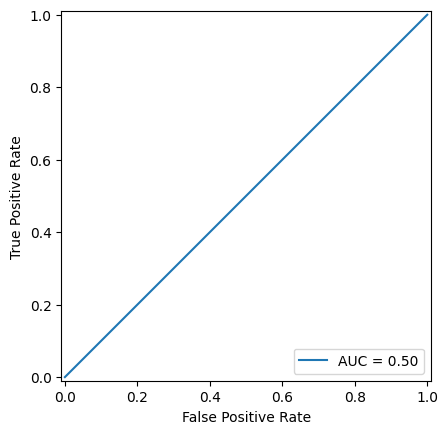

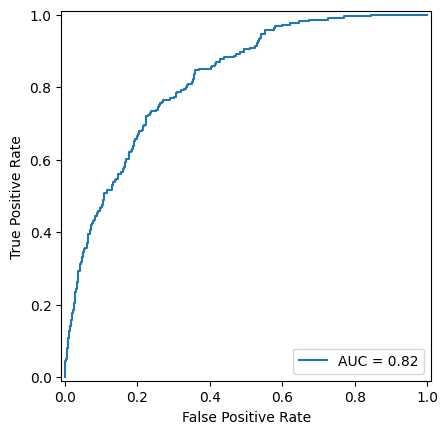

In [ ]:
y_simple_probs = np.repeat(0.25, repeats=y_test.shape[0])
y_test_probs = model_lr.predict_proba(x_test)[:, 1]

auc = roc_auc_score(y_test, y_simple_probs)
print(f"simple AUC: {auc}")

fpr, tpr, _ = roc_curve(y_test, y_simple_probs)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
disp.plot()


auc = roc_auc_score(y_test, y_test_probs)
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
disp.plot()

---

# Fitting tree ML models

In [ ]:
tree_model = XGBClassifier(max_depth = 9)
tree_model.fit(x_train, y_train)

y_test_pred = tree_model.predict(x_test)

print(classification_report(y_test, y_test_pred, digits=4))
print("roc_auc", roc_auc_score(y_test, y_test_pred))

              precision    recall  f1-score   support

           0     0.8656    0.9257    0.8947       835
           1     0.6196    0.4570    0.5260       221

    accuracy                         0.8277      1056
   macro avg     0.7426    0.6914    0.7104      1056
weighted avg     0.8141    0.8277    0.8175      1056

roc_auc 0.6913810388273227


In [ ]:
tree_model = RandomForestClassifier(max_depth = 10)
tree_model.fit(x_train, y_train)

y_test_pred = tree_model.predict(x_test)

print(classification_report(y_test, y_test_pred, digits=4))
print("roc_auc", roc_auc_score(y_test, y_test_pred))

              precision    recall  f1-score   support

           0     0.8272    0.9916    0.9020       835
           1     0.8727    0.2172    0.3478       221

    accuracy                         0.8295      1056
   macro avg     0.8500    0.6044    0.6249      1056
weighted avg     0.8367    0.8295    0.7860      1056

roc_auc 0.6044056683014063


In [ ]:
tree_model = DecisionTreeClassifier(max_depth = 14)
tree_model.fit(x_train, y_train)

y_test_pred = tree_model.predict(x_test)

print(classification_report(y_test, y_test_pred, digits=4))
print("roc_auc", roc_auc_score(y_test, y_test_pred))

              precision    recall  f1-score   support

           0     0.8599    0.9042    0.8815       835
           1     0.5506    0.4434    0.4912       221

    accuracy                         0.8078      1056
   macro avg     0.7052    0.6738    0.6864      1056
weighted avg     0.7952    0.8078    0.7998      1056

roc_auc 0.6738152653968081


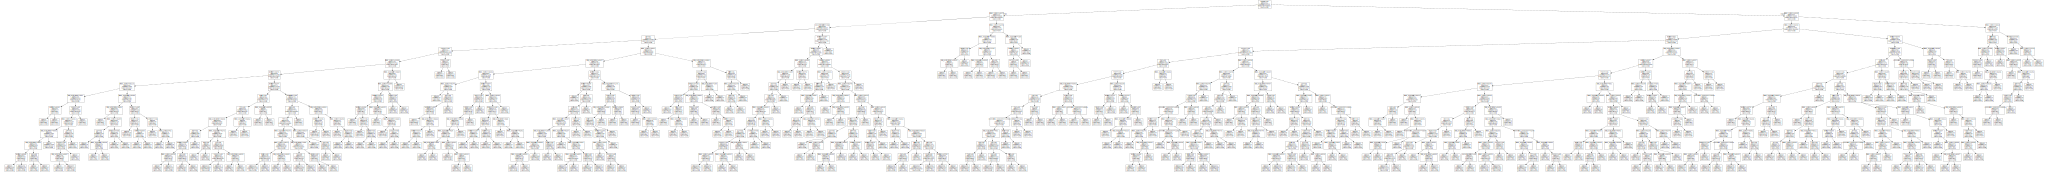

In [ ]:
graph = export_graphviz(
    tree_model,
    feature_names=x_train.columns,
    class_names=["zero", "one"],
)
graphviz.Source(graph)

Heatmap of feature correlation

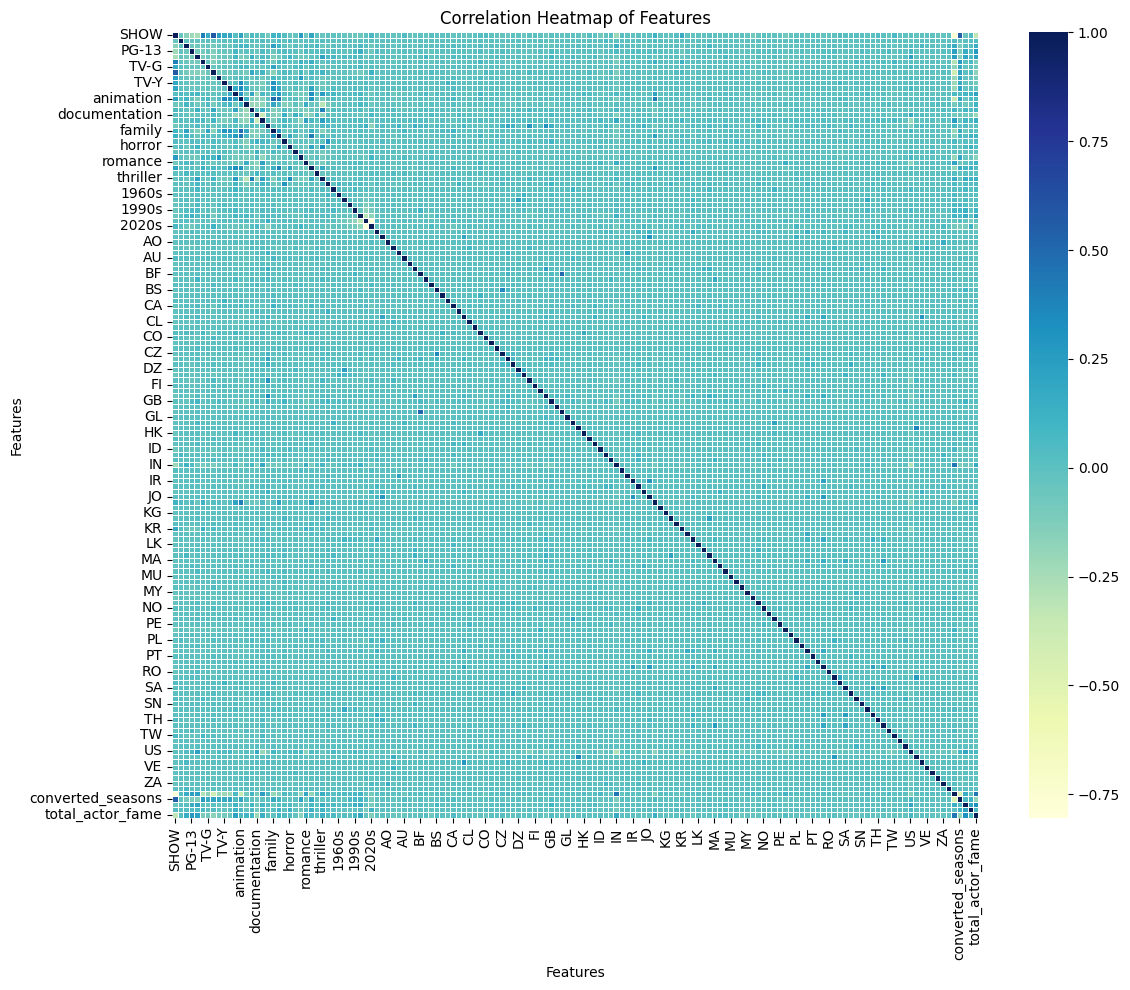

In [ ]:
correlation_matrix = features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="YlGnBu", fmt=".2f", linewidths=.5)

plt.title("Correlation Heatmap of Features")
plt.xlabel("Features")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

---

# Conclusions

All of the parameters we've selected correlate with success of a movie

From the heatmap we can concur that actor's fame, show type and age certification have higher impact on a movie's success than most of the other features

Interestingly, a linear model had a higher ROC score than tree-type models, but it was the worst at predicting successfull movies

As for the tree-type models, `XGBClassifier` showed the best results, but is still relatively poor at predicting successfull movies

At the end we can say that the given data is not enough to train a model with good prediction capabilities

Additional data like movie budget, movie earnings and promotional budget could lead to better results